# Импорт библиотек

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Загрузка данных

In [2]:
data = pd.read_csv('data/malicious_phish.csv')

# Преобразование текстовых данных в числовые признаки

In [3]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(data['url'])

# Кодирование меток (phishing, benign, defacement, malware)

In [4]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(data['type'])

# Разделение данных на обучающую и тестовую выборки

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Создание и обучение модели XGBoost

In [6]:
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model.fit(X_train, y_train)

c:\Users\91929\VSCode Projects\toipas\project_n\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [02:15:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

# Сохранение модели и векторизатора

In [7]:
joblib.dump(model, 'xgboost_model.pkl')
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')
joblib.dump(label_encoder, 'label_encoder.pkl')

['label_encoder.pkl']

# Предсказание на тестовой выборке

In [8]:
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)  # Вероятности для всех классов

# Оценка модели

In [9]:
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

Classification Report:
              precision    recall  f1-score   support

      benign       0.93      0.99      0.96     85778
  defacement       0.96      0.99      0.97     19104
     malware       0.97      0.93      0.95      6521
    phishing       0.92      0.66      0.77     18836

    accuracy                           0.94    130239
   macro avg       0.95      0.89      0.91    130239
weighted avg       0.94      0.94      0.93    130239



# Визуализация матрицы ошибок

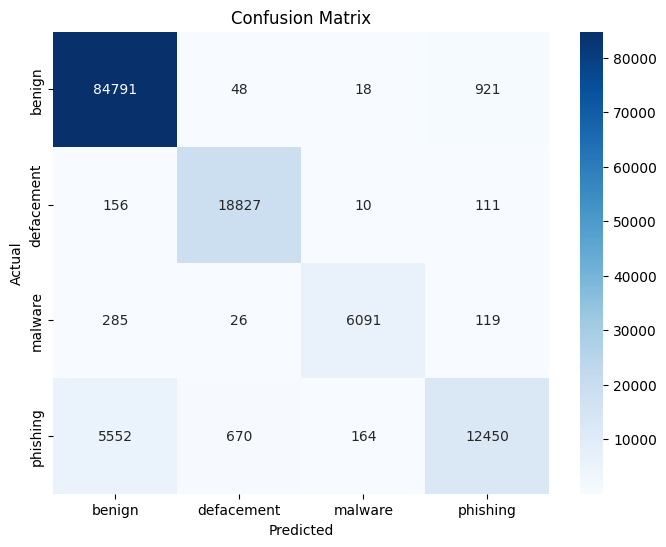

In [10]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# ROC-AUC

In [11]:
roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
print(f"\nROC-AUC Score: {roc_auc}")


ROC-AUC Score: 0.9824941007773279


# Построение ROC-кривой

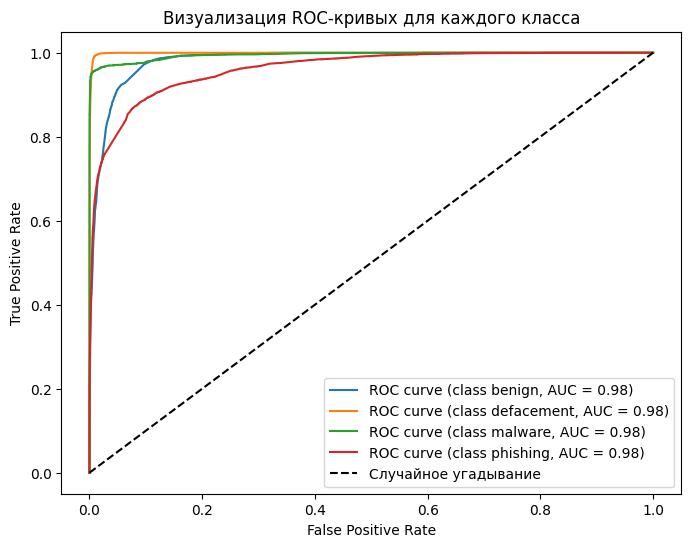

In [12]:
n_classes = len(label_encoder.classes_)
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test, y_pred_proba[:, i], pos_label=i)
    roc_auc[i] = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')

# Визуализация ROC-кривых для каждого класса
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (class {label_encoder.classes_[i]}, AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Случайное угадывание')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Визуализация ROC-кривых для каждого класса')
plt.legend(loc="lower right")
plt.show()